In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from prophet import Prophet
from openpyxl.workbook import Workbook
from matplotlib import pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import cx_Oracle
from config import oracle_wfm_key
import time
import datetime as dt
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sqlalchemy.types import String
import ipynbname
from tqdm import tqdm
import itertools
import databases as db

ods = db.oracle('cco_wfm',oracle_wfm_key)

file = ipynbname.name()
output_path=r'\\Tds\Metrocom\Contact Center\Workforce Management\Forecasting Models\Forecast Outputs\\'

In [2]:
service = ['Cable Specialist','OB_OCB_Cable_Con_Spec']
yesterday = dt.date.today() - dt.timedelta(days=1)
appended_data = []
for name in service:
    query = f'''SELECT "A1"."DateTime",
                "A1"."Queue",
                "A1"."Forecasted_AHT",
                "A1"."Forecasted_CV",
                "A1"."Actual_AHT",
                "A1"."Actual_CV"
        FROM "CCO_WFM"."Queue_Analytics" "A1"
        WHERE "A1"."Queue" = '{name}'
            AND "A1"."DateTime" <= TO_DATE('{yesterday}','YYYY-MM-DD')'''
    data = pd.read_sql(query, ods)
    appended_data.append(data)
appended_data = pd.concat(appended_data)
appended_data.head(3)

DateTime             Queue  Forecasted_AHT  Forecasted_CV  \
0 2017-02-06 13:15:00  Cable Specialist           730.0            4.0   
1 2017-02-06 13:30:00  Cable Specialist           679.0            8.0   
2 2017-02-06 13:45:00  Cable Specialist           665.0            7.0   

   Actual_AHT  Actual_CV  
0       848.0        5.0  
1       686.0        4.0  
2       686.0        4.0

## Volume Forecasts

In [3]:
grouped_cv = appended_data.groupby(['DateTime'])['Actual_CV'].sum()
grouped_cv = grouped_cv.reset_index()
grouped_cv.head(3)

DateTime  Actual_CV
0 2017-01-02 09:00:00        2.0
1 2017-01-02 09:15:00        2.0
2 2017-01-02 09:30:00        2.0

In [4]:
hourly_cv = grouped_cv.resample('1H', on='DateTime').sum()
hourly_cv.head(3)

Actual_CV
DateTime                      
2017-01-02 09:00:00        8.0
2017-01-02 10:00:00       17.0
2017-01-02 11:00:00       22.0

In [5]:
grouped_fcv = appended_data.groupby(['DateTime'])['Forecasted_CV'].sum()
grouped_fcv = grouped_fcv.reset_index()
grouped_fcv.head(3)

DateTime  Forecasted_CV
0 2017-01-02 09:00:00            2.0
1 2017-01-02 09:15:00            1.0
2 2017-01-02 09:30:00            2.0

In [6]:
hourly_fcv = grouped_fcv.resample('1H', on='DateTime').sum()
hourly_fcv.head(3)

Forecasted_CV
DateTime                          
2017-01-02 09:00:00            8.0
2017-01-02 10:00:00           10.0
2017-01-02 11:00:00           11.0

In [7]:
hourly_cv.reset_index(inplace=True)
daily_cv = hourly_cv.resample('D', on='DateTime').sum()
daily_cv.head(3)

Actual_CV
DateTime             
2017-01-02      139.0
2017-01-03      208.0
2017-01-04      178.0

In [8]:
hourly_fcv.reset_index(inplace=True)
daily_fcv = hourly_fcv.resample('D', on='DateTime').sum()
daily_fcv.head(3)

Forecasted_CV
DateTime                 
2017-01-02           97.0
2017-01-03          173.0
2017-01-04          153.0

In [9]:
daily_cv.reset_index(inplace=True)
weekly_cv = daily_cv.resample('W', label='left', on='DateTime').sum()
weekly_cv.tail(3)

Actual_CV
DateTime             
2022-10-23     2640.0
2022-10-30     2403.0
2022-11-06      621.0

In [10]:
daily_fcv.reset_index(inplace=True)
weekly_fcv = daily_fcv.resample('W', label='left', on='DateTime').sum()
weekly_fcv.tail(3)

Forecasted_CV
DateTime                 
2022-10-23         2548.0
2022-10-30         2383.0
2022-11-06          515.0

In [11]:
column_names = ['ds','for_y']
weekly_for = weekly_fcv.reset_index()
weekly_for.columns = column_names
weekly_for = weekly_for.replace(0,np.nan)
weekly_for.tail(3)

ds   for_y
303 2022-10-23  2548.0
304 2022-10-30  2383.0
305 2022-11-06   515.0

In [12]:
column_names = ['ds','y']
weekly_data = weekly_cv.reset_index()
weekly_data.columns = column_names
weekly_data = weekly_data.replace(0,np.nan)
weekly_data.tail(3)

ds       y
303 2022-10-23  2640.0
304 2022-10-30  2403.0
305 2022-11-06   621.0

#### Initiate Prophet

In [13]:
df = weekly_data
m = Prophet() 
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
future = m.make_future_dataframe(periods=104, freq='W')
future.tail(3)

ds
407 2024-10-20
408 2024-10-27
409 2024-11-03

In [15]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)


ds         yhat   yhat_lower   yhat_upper
407 2024-10-20  2183.324664  1834.260647  2519.244383
408 2024-10-27  2095.579251  1737.461102  2456.468773
409 2024-11-03  1944.040044  1592.444582  2292.814093

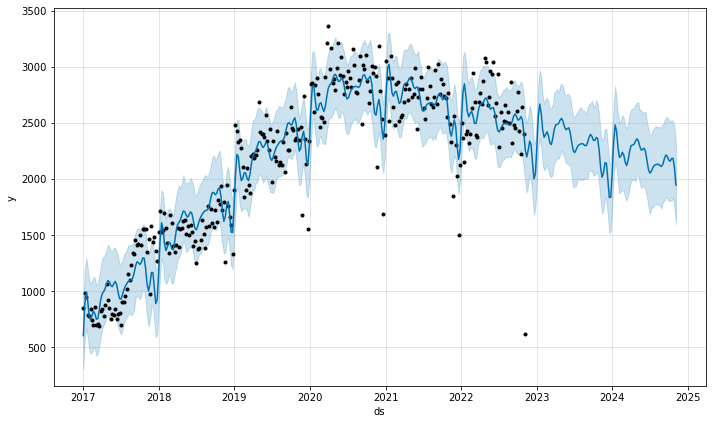

In [16]:
fig1 = m.plot(forecast)

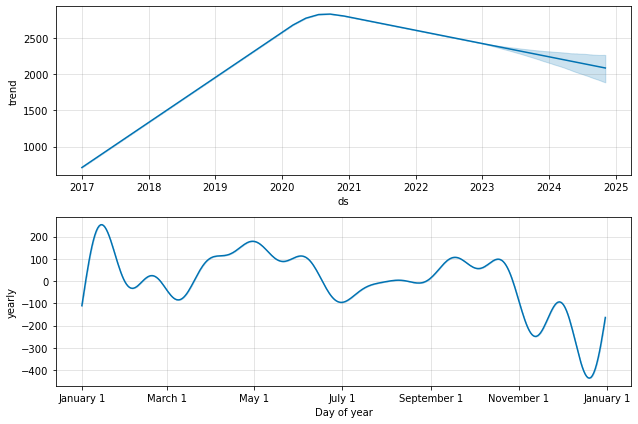

In [17]:
fig2 = m.plot_components(forecast)


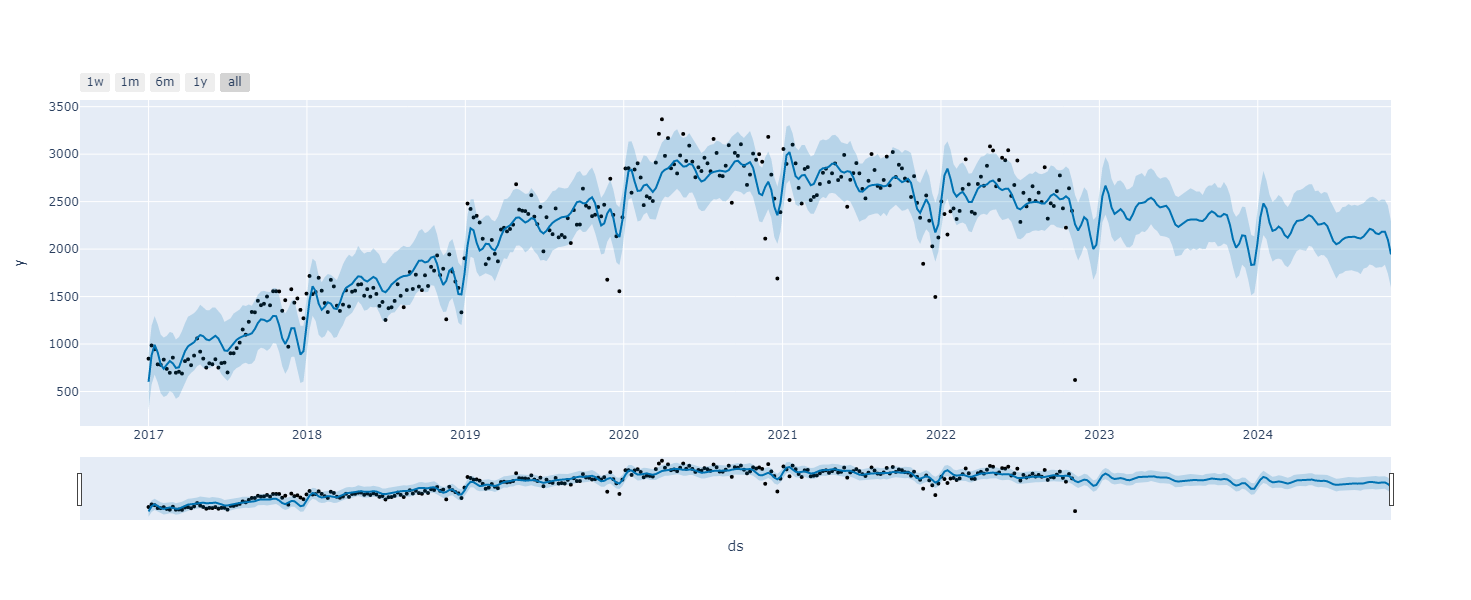

In [18]:
fig = plot_plotly(m, forecast)
plot_plotly(m, forecast)

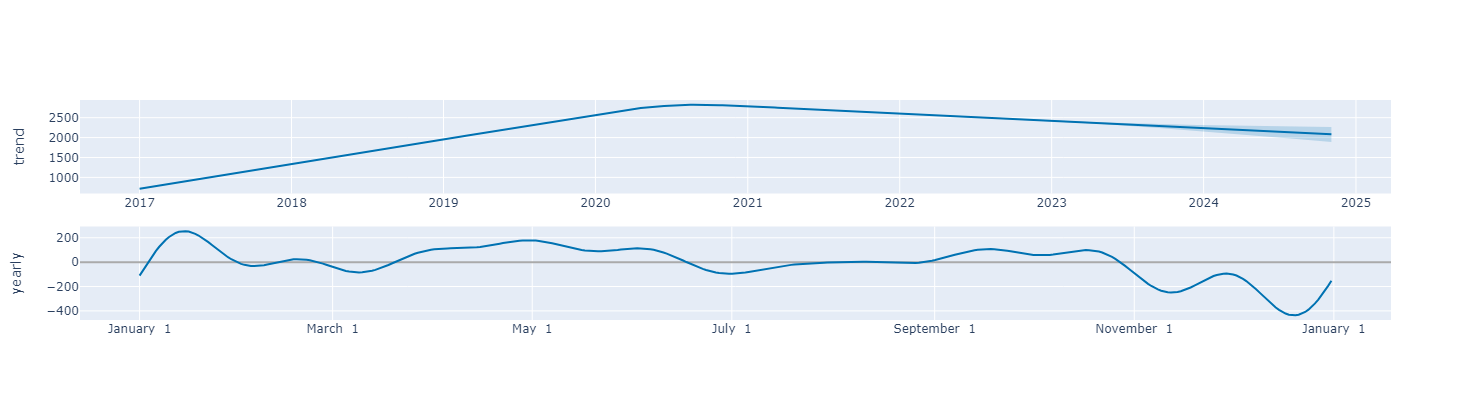

In [19]:
plot_components_plotly(m, forecast)


In [20]:
forecast.tail(3)

ds        trend   yhat_lower   yhat_upper  trend_lower  \
407 2024-10-20  2091.038783  1834.260647  2519.244383  1898.144769   
408 2024-10-27  2087.532900  1737.461102  2456.468773  1892.564862   
409 2024-11-03  2084.027017  1592.444582  2292.814093  1886.345717   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
407  2264.735622       92.285881             92.285881             92.285881   
408  2265.402233        8.046351              8.046351              8.046351   
409  2263.742069     -139.986973           -139.986973           -139.986973   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
407   92.285881     92.285881     92.285881                   0.0   
408    8.046351      8.046351      8.046351                   0.0   
409 -139.986973   -139.986973   -139.986973                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper         yhat  
407                         0.0                         0.0  2183.324664  
408                         0.0                         0.0  2095.579251  
409                         0.0                         0.0  1944.040044

#### Cross Validation

In [21]:
# create cross-validation df
df_cv = cross_validation(m, initial='1461 days', period='14 days', horizon = '30 days')
df_cv.head(3)

INFO:prophet:Making 47 forecasts with cutoffs between 2021-01-01 00:00:00 and 2022-10-07 00:00:00


  0%|          | 0/47 [00:00<?, ?it/s]

ds         yhat   yhat_lower   yhat_upper       y     cutoff
0 2021-01-03  3119.144598  2845.342462  3393.299320  3054.0 2021-01-01
1 2021-01-10  3416.433148  3133.203953  3692.031123  2897.0 2021-01-01
2 2021-01-17  3492.028751  3232.051561  3755.586747  2517.0 2021-01-01

In [22]:
# create performance metrics df
df_p = performance_metrics(df_cv)
df_p.head(3)

horizon            mse        rmse         mae      mape     mdape  \
0  2 days  100256.882493  316.633672  228.333592  0.093917  0.057467   
1  9 days   70323.010022  265.184860  220.416330  0.084955  0.070817   
2 16 days  118287.045055  343.928837  251.146919  0.103090  0.063014   

      smape  coverage  
0  0.087932  0.723404  
1  0.082623  0.659574  
2  0.095949  0.680851

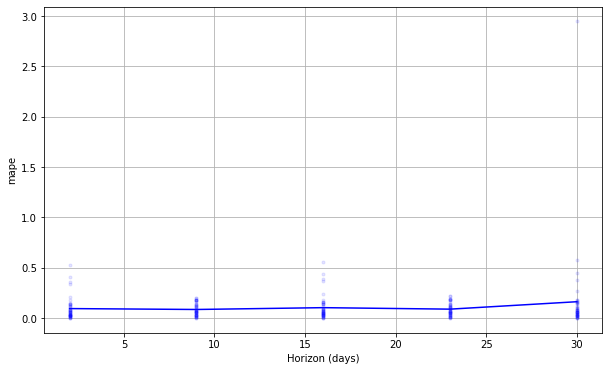

In [23]:
# plot cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mape')

### SQL Export

In [24]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# add filename as column
team = file.split('.')[0]
forecast = forecast.merge(weekly_data, on='ds',how='left')
forecast = forecast.merge(weekly_for, on='ds',how='left')
forecast['Team'] = team

# determine last row
last_row = forecast['ds'].max()
end_date = f"'{last_row}'"

# remove duplicate rows before insert
delete = f'''DELETE FROM
                    "CCO_WFM"."Forecasts_Weekly" "A1"
                WHERE
                    ("A1"."Team" = '{team}')'''

with ods as conn:
    conn.execute(delete)

In [25]:
forecast['prophet_absolute_percent_error'] = ((forecast['y'] - forecast['yhat']) / forecast['y'])
forecast['verint_absolute_percent_error'] = ((forecast['y'] - forecast['for_y']) / forecast['y'])
forecast

ds        trend   yhat_lower   yhat_upper  trend_lower  \
0   2017-01-01   712.915467   308.443224   909.752023   712.915467   
1   2017-01-08   724.820215   572.847188  1192.734327   724.820215   
2   2017-01-15   736.724962   676.760690  1294.461014   736.724962   
3   2017-01-22   748.629710   596.110384  1209.878931   748.629710   
4   2017-01-29   760.534458   481.894434  1100.310465   760.534458   
..         ...          ...          ...          ...          ...   
405 2024-10-06  2098.050549  1807.833396  2505.687826  1911.930841   
406 2024-10-13  2094.544666  1809.368720  2523.043643  1905.625116   
407 2024-10-20  2091.038783  1834.260647  2519.244383  1898.144769   
408 2024-10-27  2087.532900  1737.461102  2456.468773  1892.564862   
409 2024-11-03  2084.027017  1592.444582  2292.814093  1886.345717   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0     712.915467     -110.642519           -110.642519           -110.642519   
1     724.820215      156.734990            156.734990            156.734990   
2     736.724962      254.090818            254.090818            254.090818   
3     748.629710      164.045537            164.045537            164.045537   
4     760.534458       24.090238             24.090238             24.090238   
..           ...             ...                   ...                   ...   
405  2264.049151       59.471591             59.471591             59.471591   
406  2264.137851       88.346133             88.346133             88.346133   
407  2264.735622       92.285881             92.285881             92.285881   
408  2265.402233        8.046351              8.046351              8.046351   
409  2263.742069     -139.986973           -139.986973           -139.986973   

         yearly  ...  yearly_upper  multiplicative_terms  \
0   -110.642519  ...   -110.642519                   0.0   
1    156.734990  ...    156.734990                   0.0   
2    254.090818  ...    254.090818                   0.0   
3    164.045537  ...    164.045537                   0.0   
4     24.090238  ...     24.090238                   0.0   
..          ...  ...           ...                   ...   
405   59.471591  ...     59.471591                   0.0   
406   88.346133  ...     88.346133                   0.0   
407   92.285881  ...     92.285881                   0.0   
408    8.046351  ...      8.046351                   0.0   
409 -139.986973  ...   -139.986973                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper         yhat  \
0                           0.0                         0.0   602.272948   
1                           0.0                         0.0   881.555204   
2                           0.0                         0.0   990.815781   
3                           0.0                         0.0   912.675247   
4                           0.0                         0.0   784.624696   
..                          ...                         ...          ...   
405                         0.0                         0.0  2157.522140   
406                         0.0                         0.0  2182.890799   
407                         0.0                         0.0  2183.324664   
408                         0.0                         0.0  2095.579251   
409                         0.0                         0.0  1944.040044   

         y  for_y             Team prophet_absolute_percent_error  \
0    846.0  734.0  cable_retention                       0.288093   
1    985.0  879.0  cable_retention                       0.105020   
2    945.0  674.0  cable_retention                      -0.048482   
3    786.0  920.0  cable_retention                      -0.161164   
4    781.0  974.0  cable_retention                      -0.004641   
..     ...    ...              ...                            ...   
405    NaN    NaN  cable_retention                            NaN   
406    NaN    NaN  cable

In [26]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# Import forecast to database
rows_imported = 0
start_time = time.time()

cols = forecast.dtypes[forecast.dtypes=='object'].index
type_mapping = {col : String(100) for col in cols }

print(f'importing rows {rows_imported} to {rows_imported + len(forecast)}...', end='')
forecast.to_sql('Forecasts_Weekly',ods,schema='CCO_WFM',if_exists='append',index=False,dtype=type_mapping)
rows_imported += len(df)

end_time = time.time() - start_time
print(f'Done. {end_time} total seconds have elapsed.')

importing rows 0 to 410...Done. 0.6040499210357666 total seconds have elapsed.


## AHT Forecasts

In [27]:
appended_data['Adj_AHT'] = appended_data['Actual_AHT'] * appended_data['Actual_CV']
appended_data['Adj_AHT'] = appended_data['Adj_AHT'].replace(0, np.nan)
grouped_aht = appended_data.groupby(['DateTime'])['Adj_AHT'].sum()
grouped_aht = grouped_aht.reset_index()
grouped_aht.head(3)

DateTime  Adj_AHT
0 2017-01-02 09:00:00    770.0
1 2017-01-02 09:15:00    770.0
2 2017-01-02 09:30:00   1088.0

In [28]:
hourly_aht = grouped_aht.resample('1H', on='DateTime').sum()
hourly_aht.head(3)

Adj_AHT
DateTime                    
2017-01-02 09:00:00   3716.0
2017-01-02 10:00:00  10589.0
2017-01-02 11:00:00  13261.0

In [29]:
hourly_aht.reset_index(inplace=True)
daily_aht = hourly_aht.resample('D', on='DateTime').sum()
daily_aht.head(3)

Adj_AHT
DateTime            
2017-01-02   80347.0
2017-01-03  127329.0
2017-01-04  106290.0

In [30]:
daily_aht.reset_index(inplace=True)
weekly_aht = daily_aht.resample('W', label='left', on='DateTime').sum()
weekly_aht.tail(3)

Adj_AHT
DateTime             
2022-10-23  1332711.0
2022-10-30  1316867.0
2022-11-06   309360.0

In [31]:
weekly_cv.tail(3)

Actual_CV
DateTime             
2022-10-23     2640.0
2022-10-30     2403.0
2022-11-06      621.0

In [32]:
combined_aht = weekly_aht.drop(columns=['Adj_AHT'])
combined_aht['Actual_AHT'] = weekly_aht['Adj_AHT'] / weekly_cv['Actual_CV']
column_names = ['ds','y']
weekly_data = combined_aht.reset_index()
weekly_data.columns = column_names
weekly_data.tail(3)

ds           y
303 2022-10-23  504.814773
304 2022-10-30  548.009571
305 2022-11-06  498.164251

In [33]:
appended_data['Adj_for'] = appended_data['Forecasted_AHT'] * appended_data['Forecasted_CV']
appended_data['Adj_for'] = appended_data['Adj_for'].replace(0, np.nan)
grouped_for = appended_data.groupby(['DateTime'])['Adj_for'].sum()
grouped_for = grouped_for.reset_index()
grouped_for.head(3)

DateTime  Adj_for
0 2017-01-02 09:00:00    496.0
1 2017-01-02 09:15:00    303.0
2 2017-01-02 09:30:00    728.0

In [34]:
hourly_faht = grouped_for.resample('1H', on='DateTime').sum()
hourly_faht.head(3)

Adj_for
DateTime                    
2017-01-02 09:00:00   2706.0
2017-01-02 10:00:00   5393.0
2017-01-02 11:00:00   4968.0

In [35]:
hourly_faht.reset_index(inplace=True)
daily_faht = hourly_faht.resample('D', on='DateTime').sum()
daily_faht.head(3)

Adj_for
DateTime           
2017-01-02  48156.0
2017-01-03  79780.0
2017-01-04  86314.0

In [36]:
daily_faht.reset_index(inplace=True)
weekly_faht = daily_faht.resample('W', label='left', on='DateTime').sum()
weekly_faht.tail(3)

Adj_for
DateTime             
2022-10-23  1295501.0
2022-10-30  1207343.0
2022-11-06   272293.0

In [37]:
weekly_fcv.tail(3)

Forecasted_CV
DateTime                 
2022-10-23         2548.0
2022-10-30         2383.0
2022-11-06          515.0

In [38]:
combined_for = weekly_faht.drop(columns=['Adj_for'])
combined_for['Forecasted_AHT'] = weekly_faht['Adj_for'] / weekly_fcv['Forecasted_CV']
column_names = ['ds','for_y']
weekly_for_aht = combined_for.reset_index()
weekly_for_aht.columns = column_names
weekly_for_aht.tail(3)

ds       for_y
303 2022-10-23  508.438383
304 2022-10-30  506.648342
305 2022-11-06  528.724272

#### Initiate Prophet

In [39]:
df = weekly_data
m = Prophet() 
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
future = m.make_future_dataframe(periods=104, freq='W')
future.tail(3)

ds
407 2024-10-20
408 2024-10-27
409 2024-11-03

In [41]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)


ds        yhat  yhat_lower  yhat_upper
407 2024-10-20  390.128836  329.247002  448.656855
408 2024-10-27  380.763703  323.097025  441.000372
409 2024-11-03  374.400834  310.908097  436.498041

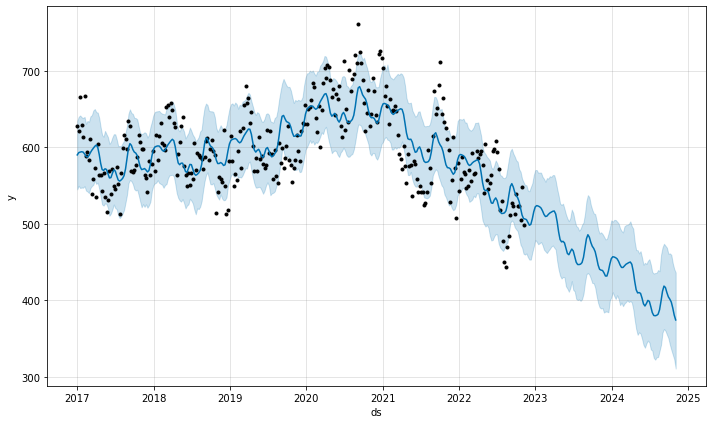

In [42]:
fig1 = m.plot(forecast)

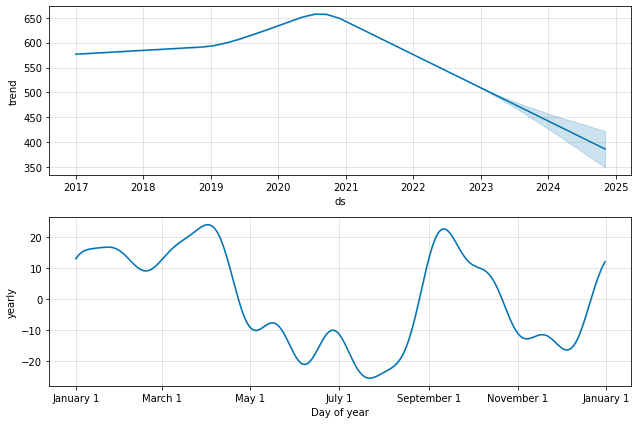

In [43]:
fig2 = m.plot_components(forecast)


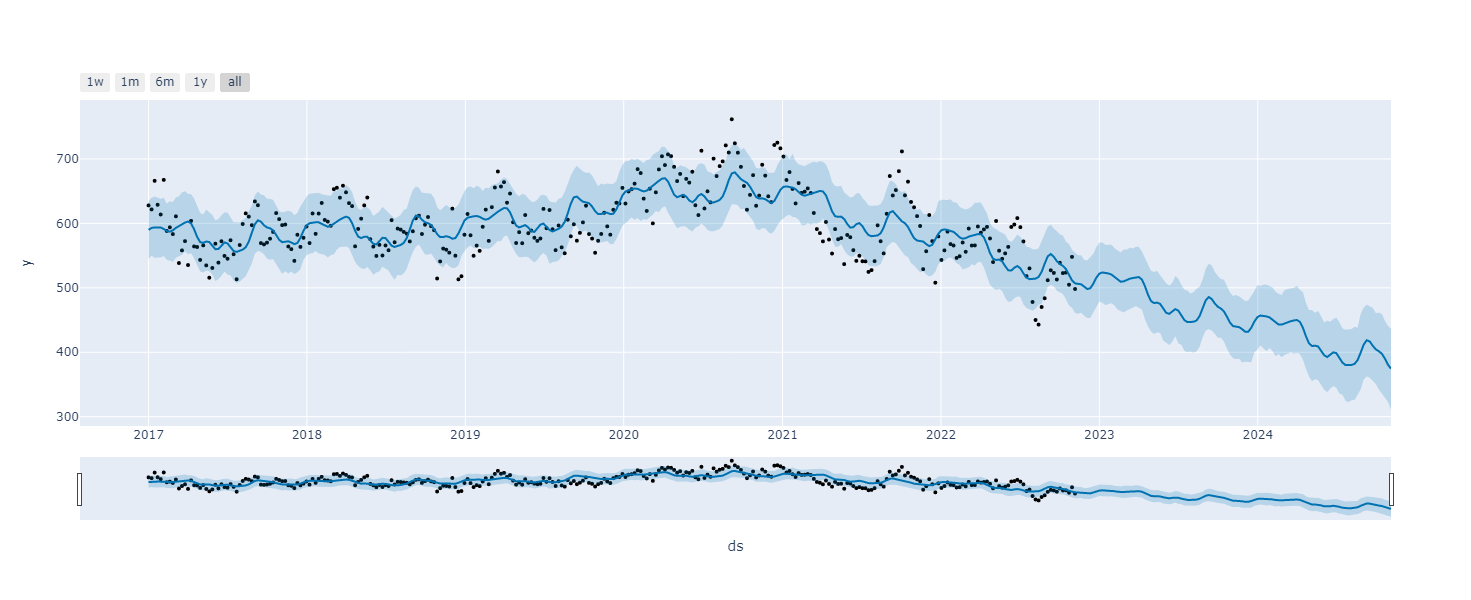

In [44]:
fig = plot_plotly(m, forecast)
plot_plotly(m, forecast)

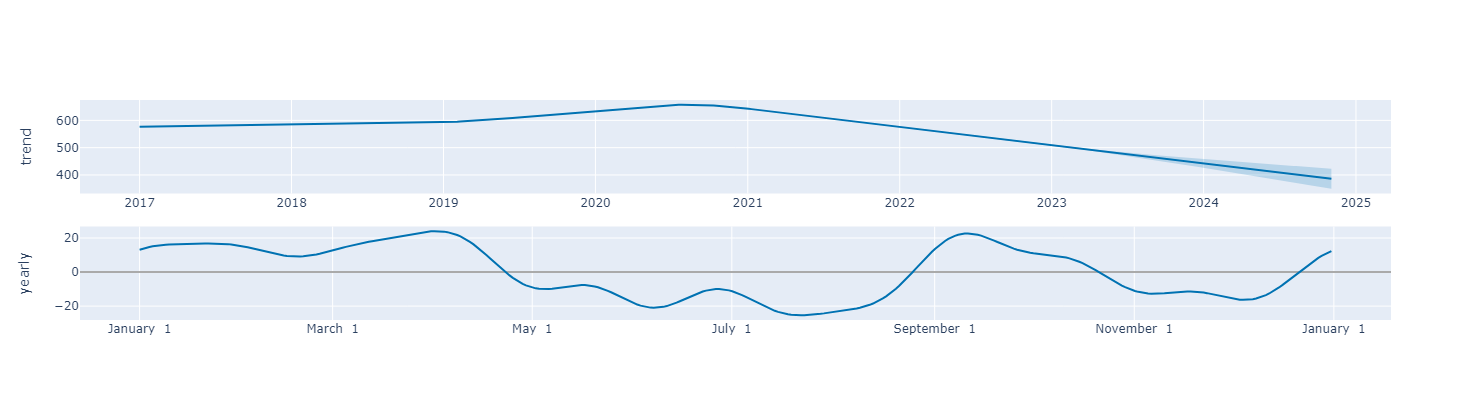

In [45]:
plot_components_plotly(m, forecast)


In [46]:
forecast.tail(3)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
407 2024-10-20  389.016509  329.247002  448.656855   353.326036   424.305315   
408 2024-10-27  387.736582  323.097025  441.000372   351.287345   423.539395   
409 2024-11-03  386.456656  310.908097  436.498041   349.173899   422.985972   

     additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
407        1.112327              1.112327              1.112327   1.112327   
408       -6.972879             -6.972879             -6.972879  -6.972879   
409      -12.055821            -12.055821            -12.055821 -12.055821   

     yearly_lower  yearly_upper  multiplicative_terms  \
407      1.112327      1.112327                   0.0   
408     -6.972879     -6.972879                   0.0   
409    -12.055821    -12.055821                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
407                         0.0                         0.0  390.128836  
408                         0.0                         0.0  380.763703  
409                         0.0                         0.0  374.400834

#### Cross Validate

In [47]:
# create cross-validation df
df_cv = cross_validation(m, initial='1461 days', period='14 days', horizon = '30 days')
df_cv.head(3)

INFO:prophet:Making 47 forecasts with cutoffs between 2021-01-01 00:00:00 and 2022-10-07 00:00:00


  0%|          | 0/47 [00:00<?, ?it/s]

ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2021-01-03  723.931016  684.240590  760.271387  703.739686 2021-01-01
1 2021-01-10  726.721471  688.148363  764.639135  667.417673 2021-01-01
2 2021-01-17  729.145567  693.066111  769.709087  679.597139 2021-01-01

In [48]:
# create performance metrics df
df_p = performance_metrics(df_cv)
df_p.head(3)

horizon          mse       rmse        mae      mape     mdape     smape  \
0  2 days  3293.524730  57.389239  48.369843  0.084355  0.077018  0.082058   
1  9 days  3951.514849  62.861076  49.699994  0.084262  0.075053  0.082699   
2 16 days  4487.980193  66.992389  56.426490  0.098357  0.088767  0.095359   

   coverage  
0  0.468085  
1  0.574468  
2  0.425532

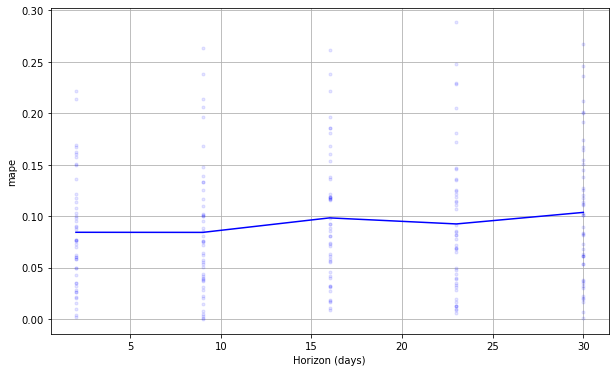

In [49]:
# plot cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [50]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# add filename as column
team = file.split('.')[0]
forecast = forecast.merge(weekly_data, on='ds',how='left')
forecast = forecast.merge(weekly_for_aht, on='ds',how='left')
forecast['Team'] = team

# determine last row
last_row = forecast['ds'].max()
end_date = f"'{last_row}'"

# remove duplicate rows before insert
delete = f'''DELETE FROM
                    "CCO_WFM"."Forecasts_Weekly_AHT" "A1"
                WHERE
                    ("A1"."Team" = '{team}')'''

with ods as conn:
    conn.execute(delete)

In [51]:
forecast['prophet_absolute_percent_error'] = ((forecast['y'] - forecast['yhat']) / forecast['y'])
forecast['verint_absolute_percent_error'] = ((forecast['y'] - forecast['for_y']) / forecast['y'])
forecast

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2017-01-01  576.925334  544.988965  634.452740   576.925334   576.925334   
1   2017-01-08  577.071900  549.724899  639.860367   577.071900   577.071900   
2   2017-01-15  577.218465  546.753729  641.563816   577.218465   577.218465   
3   2017-01-22  577.365030  547.392337  639.282608   577.365030   577.365030   
4   2017-01-29  577.511595  547.151083  638.186503   577.511595   577.511595   
..         ...         ...         ...         ...          ...          ...   
405 2024-10-06  391.576362  342.444012  461.369244   356.483824   425.804481   
406 2024-10-13  390.296435  335.514913  459.573608   354.906967   425.119497   
407 2024-10-20  389.016509  329.247002  448.656855   353.326036   424.305315   
408 2024-10-27  387.736582  323.097025  441.000372   351.287345   423.539395   
409 2024-11-03  386.456656  310.908097  436.498041   349.173899   422.985972   

     additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
0         13.080671             13.080671             13.080671  13.080671   
1         15.865358             15.865358             15.865358  15.865358   
2         16.483429             16.483429             16.483429  16.483429   
3         16.808016             16.808016             16.808016  16.808016   
4         16.228082             16.228082             16.228082  16.228082   
..              ...                   ...                   ...        ...   
405        9.992897              9.992897              9.992897   9.992897   
406        7.444544              7.444544              7.444544   7.444544   
407        1.112327              1.112327              1.112327   1.112327   
408       -6.972879             -6.972879             -6.972879  -6.972879   
409      -12.055821            -12.055821            -12.055821 -12.055821   

     ...  yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0    ...     13.080671                   0.0                         0.0   
1    ...     15.865358                   0.0                         0.0   
2    ...     16.483429                   0.0                         0.0   
3    ...     16.808016                   0.0                         0.0   
4    ...     16.228082                   0.0                         0.0   
..   ...           ...                   ...                         ...   
405  ...      9.992897                   0.0                         0.0   
406  ...      7.444544                   0.0                         0.0   
407  ...      1.112327                   0.0                         0.0   
408  ...     -6.972879                   0.0                         0.0   
409  ...    -12.055821                   0.0                         0.0   

     multiplicative_terms_upper        yhat           y       for_y  \
0                           0.0  590.006006  627.877069  535.903270   
1                           0.0  592.937257  621.705584  588.006826   
2                           0.0  593.701894  666.011640  594.146884   
3                           0.0  594.173046  628.917303  612.580435   
4                           0.0  593.739677  613.781050  608.564682   
..                          ...         ...         ...         ...   
405                         0.0  401.569259         NaN         NaN   
406                         0.0  397.740979         NaN         NaN   
407                         0.0  390.128836         NaN         NaN   
408                         0.0  380.763703         NaN         NaN   
409                         0.0  374.400834         NaN         NaN   

                Team prophet_absolute_percent_error  \
0    cable_retention                       0.060316   
1    cable_retention                       0.046273   
2    cable_retention                       0.108571   
3    cable_retention                       0.055245   
4    cable_retention                       0.032652   
..               .

In [52]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# Import forecast to database
rows_imported = 0
start_time = time.time()

cols = forecast.dtypes[forecast.dtypes=='object'].index
type_mapping = {col : String(100) for col in cols }

print(f'importing rows {rows_imported} to {rows_imported + len(forecast)}...', end='')
forecast.to_sql('Forecasts_Weekly_AHT',ods,schema='CCO_WFM',if_exists='append',index=False,dtype=type_mapping)
rows_imported += len(df)

end_time = time.time() - start_time
print(f'Done. {end_time} total seconds have elapsed.')

importing rows 0 to 410...Done. 0.0859980583190918 total seconds have elapsed.
